In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing, svm, metrics
from sklearn.model_selection import LeaveOneGroupOut, KFold, GridSearchCV, GroupKFold, cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.externals import joblib
from sklearn.datasets import make_regression
from scipy.stats import randint as sp_randint
from matplotlib import pyplot as plt
from collections import defaultdict

/Users/Zach/miniconda3/envs/ml_22.2/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
%matplotlib inline
import biom
import calour as ca
from scipy import stats
import scipy
import pickle
import time
import math
import inspect
import operator
pd.set_option('display.max_rows', 10000)

/Users/Zach/miniconda3/envs/ml_22.2/lib/python3.7/site-packages/skbio/util/_testing.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as pdt


# Importing data, no TSS normalization performed here since table is already normalized

In [3]:
allMetab = ca.read_amplicon('PMI_MS1_FeatureTable_Normalized.biom','pmi3_metab_meta.txt', min_reads=1, normalize = None)

## Remove controls and samples that grouped with controls on PCoA

In [4]:
allMetab = allMetab.filter_samples('control', 'n')
allMetab = allMetab.filter_samples('pcoa_removals', 'n')
allMetab.sample_metadata.description.value_counts()

skin.hip    746
soil.hip    744
Name: description, dtype: int64

# Split by sampling location (soil v. skin)

## Skin sample filtering

In [5]:
Metab_skin = allMetab.filter_samples('sample_type', 'skin')
Metab_skin.sample_metadata.sample_type.value_counts()

skin    746
Name: sample_type, dtype: int64

In [6]:
print("Number of samples: ",len(Metab_skin.sample_metadata.metab_barcode.value_counts()))

Number of samples:  746


In [7]:
print("Number of bodies: ",len(Metab_skin.sample_metadata.subjectID.value_counts()))

Number of bodies:  36


# Skin General Model using ADD 0C as Response and Adding Metadata as Features

In [8]:
Metab_skin_meta = Metab_skin.add_sample_metadata_as_features(['facility','avg_percent_humidity','total_precipitation_cm'])
print("Number of features: ",len(Metab_skin_meta.feature_metadata))

Number of features:  4405


In [9]:
# designate data
X = Metab_skin_meta.data
y = Metab_skin_meta.sample_metadata['add_0c']
y = (y.astype(float))

# group by body
groups = Metab_skin_meta.sample_metadata['subjectID']

In [10]:
# outer_cv creates 36 folds by leave-one-body-out for estimating generalization error
outer_cv = LeaveOneGroupOut().split(X, y, groups=groups)

# prints the number of folds in the outer loop
print("Number of outer folds to perform: ", LeaveOneGroupOut().get_n_splits(X, y, groups=groups))

# hyperparameter grid to test
#param_grid = {"max_depth": [None, 4],
#              "max_features": ['auto', 0.2],
#              "bootstrap": [True, False]}

param_grid = {"max_depth": [4],
              "max_features": [0.1],
              "bootstrap": [False]}

# creates loop iteration counter and empty lists for storage
count=1
model_parameters = []
nested_cv_scores = []

# loops through the sets of training and test ids in the outer loop
# the number of loops will match the number of folds as each fold is used
for train_ids, test_ids in outer_cv:
    # inner_cv creates 35 folds by leave-one-body-out for hyperparamter tuning
    # uses only the train ids present in the current outer loop fold which is one less body since the outer loop
    # folds are also using leave-one-body-out
    inner_cv = LeaveOneGroupOut().split(X[train_ids, :], y.iloc[train_ids], groups=groups[train_ids])
    # setting rf parameters
    rf = RandomForestRegressor(n_estimators=100, random_state=999, criterion='mae')
    # grid search cv using rf and the hyperparameter grid on the inner_cv training set
    rf_grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=inner_cv, n_jobs=-1, scoring='neg_mean_absolute_error')
    # fit the grid search model on the inner_cv training set, which will tell us the best
    # parameters chosen by that inner cv
    rf_grid.fit(X[train_ids, :], y.iloc[train_ids])
    # converts best params dict to string to save it
    res = ",".join(("{}={}".format(*i) for i in rf_grid.best_params_.items()))
    # attaches each loops best params
    model_parameters.append(res)
    # prints outer fold number the loop is currently on
    print("Outer fold:",count)
    # prints number of inner folds in the outer loop (should be the same each time at 35)
    print("Number of inner folds:",LeaveOneGroupOut().get_n_splits(X[train_ids, :], y.iloc[train_ids], groups=groups[train_ids]))
    # prints best param and CV score from this inner loop set 
    print("Best params:",rf_grid.best_params_)
    print("Best CV score (MAE):",-rf_grid.best_score_)
    # uses the best model created from the inner loop to predict the outer loop body left out
    yhat = rf_grid.predict(X[test_ids,:])
    MAE = mean_absolute_error(y.iloc[test_ids], yhat)
    print("Prediction score (MAE):",MAE)
    nested_cv_scores.append(MAE)
    print("*****")
    count+=1
# prints the mean of the nested cv score (generalization error) of the models
print("\nNested CV score (generalization error): " + str(np.mean(nested_cv_scores)))

Number of outer folds to perform:  36
Outer fold: 1
Number of inner folds: 35
Best params: {'bootstrap': False, 'max_depth': 4, 'max_features': 0.1}
Best CV score (MAE): 65.91586820117715
Prediction score (MAE): 27.488470900428577
*****
Outer fold: 2
Number of inner folds: 35
Best params: {'bootstrap': False, 'max_depth': 4, 'max_features': 0.1}
Best CV score (MAE): 65.20433772361417
Prediction score (MAE): 46.72264682623094
*****
Outer fold: 3
Number of inner folds: 35
Best params: {'bootstrap': False, 'max_depth': 4, 'max_features': 0.1}
Best CV score (MAE): 63.94005367730241
Prediction score (MAE): 64.83881349230006
*****
Outer fold: 4
Number of inner folds: 35
Best params: {'bootstrap': False, 'max_depth': 4, 'max_features': 0.1}
Best CV score (MAE): 63.45935035596604
Prediction score (MAE): 74.82217989397618
*****
Outer fold: 5
Number of inner folds: 35
Best params: {'bootstrap': False, 'max_depth': 4, 'max_features': 0.1}
Best CV score (MAE): 62.44887658422439
Prediction score (M

In [11]:
# define function to merge 2 lists as paired tuples    
def merge(list1, list2): 
    merged_list = tuple(zip(list1, list2))  
    return merged_list 

# merge parameters to nested scores as tuples
merged_list = merge(model_parameters, nested_cv_scores)

# puts the paired tuple list into a dictionary
params_and_scores = defaultdict(list)
for k, v in merged_list:
    params_and_scores[k].append(v)

In [12]:
# prints dict of params and scores, should see each set of parameters chosen and their scores
params_and_scores

defaultdict(list,
            {'bootstrap=False,max_depth=4,max_features=0.1': [27.488470900428577,
              46.72264682623094,
              64.83881349230006,
              74.82217989397618,
              120.61024734211428,
              94.75559919778814,
              79.21457671930233,
              55.64408479562369,
              68.3410634912595,
              81.65698677189997,
              64.4904682535143,
              67.70965079349762,
              31.8416083333475,
              36.70196296244525,
              40.523492062528575,
              64.81820767590001,
              69.60648015824047,
              70.02902645435238,
              52.77140608370711,
              52.506580687988084,
              37.646310847354755,
              64.71991666599526,
              165.98120588088233,
              47.92182142987858,
              47.351678570188064,
              48.00079365094048,
              38.96536111912146,
              65.12162037109287,
      

In [13]:
# create a dict to assign the mean score to each param set
avgDict = {}
for k,v in params_and_scores.items():
    avgDict[k] = sum(v)/ float(len(v))
print(avgDict)

{'bootstrap=False,max_depth=4,max_features=0.1': 63.82650457276999}


In [14]:
# prints the param set with the best mean error
print("Best params:",min(avgDict, key=avgDict.get))
print("Best mean score:",min(avgDict.values()))

Best params: bootstrap=False,max_depth=4,max_features=0.1
Best mean score: 63.82650457276999


In [15]:
# input the best parameter set
best_model_params = {"max_depth": [4],
              "max_features": [0.1],
              "bootstrap": [False]}

# now we refit this best model on the whole dataset so that we can start
# making predictions on other data, and now we have a reliable estimate of
# this model's generalization error and we are confident this is the best model
# among the ones we have tried
final_regressor = GridSearchCV(rf, best_model_params, cv=LeaveOneGroupOut().split(X, y, groups=groups), scoring='neg_mean_absolute_error', n_jobs=-1)
final_regressor.fit(X, y)
print("Best CV score:",-final_regressor.best_score_)

Best CV score: 73.63133209479525


In [16]:
joblib.dump(final_regressor.best_estimator_, 'models/PMI3_Metab_skin_meta_general.pkl')

['models/PMI3_Metab_skin_meta_general.pkl']

In [17]:
model_Metab_skin_meta = joblib.load('models/PMI3_Metab_skin_meta_general.pkl')

In [18]:
model_Metab_skin_meta

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mae',
                      max_depth=4, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=999, verbose=0, warm_start=False)

### Determine important features

In [19]:
importances = model_Metab_skin_meta.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_Metab_skin_meta.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feature_metadata = Metab_skin_meta.feature_metadata
np.savetxt("feature_metadata/general_skin_feature_metadata_meta.csv", feature_metadata, delimiter=",", fmt='%s')


#print the important ids in order
general_importances = []
count = 0
print("Feature:\t\t\t\tImportance:")
for i in indices:
    general_importances += (Metab_skin_meta.feature_metadata.index.values[i], importances[indices[count]])
    if count < 25:
        print(str(count+1)+". "+str(Metab_skin_meta.feature_metadata.index.values[i])+"\t"+str(importances[indices[count]]))
    count += 1

Feature:				Importance:
1. X352.356264209747_8.29605718749999	0.6324652035438103
2. X338.340748569973_8.40681924398625	0.08061073951457341
3. X107.05016949712_2.39438843537415	0.06260276439696616
4. X228.23079588292_6.35603299435028	0.03677813705034451
5. X533.380648295084_8.47133075396825	0.036586850494819044
6. X385.345282590478_7.96857988721804	0.03088780236087188
7. X155.106590406138_3.54257160493827	0.0276508624722718
8. X343.293593163583_4.6008931372549	0.02163570725428231
9. X265.251858191667_7.72115745216515	0.015199479461720022
10. X263.236161361039_6.05773919141913	0.013851460740621359
11. X283.156700489768_3.58938279569892	0.01098108616853444
12. X302.193749861283_3.73825151515151	0.010280912785705221
13. X223.127297351815_2.96714713391136	0.006798727931249925
14. X371.226813708116_2.44013158756137	0.006275748859615315
15. X304.258972599821_7.24066242138364	0.0015730898287512293
16. X402.333442687988_7.47111091954022	0.0014520829188472881
17. X703.706063406808_8.298142857142

In [20]:
print("Number of features present:", int(len(general_importances)/2))
general_importances_df = pd.DataFrame(np.array(general_importances).reshape(int(len(general_importances)/2),2))

np.savetxt("importances/general_skin_importances_meta.csv", general_importances_df, delimiter=",", fmt='%s')

Number of features present: 4405


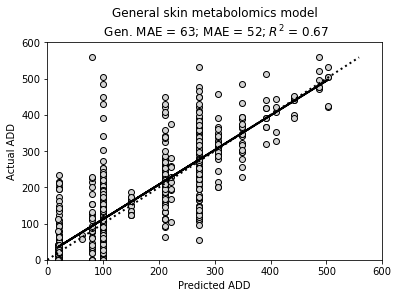

In [21]:
yhat = model_Metab_skin_meta.predict(X)
MAE = mean_absolute_error(y, yhat)

plt.scatter(yhat, y, color = 'lightgray', edgecolors = 'black')
lower = np.min(np.concatenate([y, yhat]))
upper = np.max(np.concatenate([y, yhat]))
plt.plot([lower, upper], [lower, upper], color = 'black', lw = 2, ls = ':')
plt.xlim(0,600)
plt.ylim(0,600)

#regression part
slope, intercept, r_value, p_value, std_err = stats.linregress(yhat,y)
line = slope*yhat+intercept
plt.plot(yhat, line, color = 'black', lw = 2)

plt.title('General skin metabolomics model\n Gen. MAE = %d; MAE = %d; $R^2$ = %.2f' %(np.mean(nested_cv_scores),MAE,round(model_Metab_skin_meta.score(X,y),2)))
plt.xlabel("Predicted ADD")
plt.ylabel("Actual ADD")
plt.savefig('figures/general_skin_model.png')